# Распределение статей по рецензентам

In [109]:
import numpy as np
from scipy import linalg
import pylab as plt
import pandas as pd
%matplotlib inline

## Нахождение оптимального распределения методом градиентного спуска. 

Итак, поставим формально задачу распределения статей по рецензентам. Пусть имеется $n$ рецензентов и $m$ статей, которые нуждаются в рецензии. Обозначим через $s_{rp}$ показатель качества пары $(r, p)$, который выражает насколько рецензенту $r$ подходит статья $p$ по его научным интересам (suitability), $S = \{s_{rp}\}_{r=1..n, p=1..m}$  -- соответствующая матрица размера $n \times m$. Можно полагать, что качество распределения статей по рецензентам определяется суммой показателей качества пар, входящих в предложенное распределение. Помимо этого, целесообразно наложить определенные ограничения на распределение: каждый рецензент должен прочитать не слишком много и не слишком мало статей, а каждая статья должна быть прочитана не слишком маленьким и не слишком большим числом рецензентов. Пусть $y_{rp} = 1$, если рецензенту $r$ поручено прочитать статью $p$, и $y_{rp} = 0$ в противном случае. При наличии известной матрицы $S$ задачу нахождения оптимальной 0-1 матрицы $Y=\{y_{rp}\}_{r=1..n, p=1..m}$ можно формально записать следующим образом : 
\begin{align}
J(Y, S) = \mathsf{tr}(S^TY) = \sum\limits_{r, p} s_{rp}y_{rp} \to \max\limits_{Y} \\
    \text{s.t.}
    \begin{cases}
        R_{min} \leqslant \sum\limits_{p} y_{rp} \leqslant R_{max} & \forall r = 1..n \\
        P_{min} \leqslant \sum\limits_{r} y_{rp} \leqslant P_{max} & \forall p = 1..m \\
        y_{rp} \in \{0, 1\} & \forall r = 1..n, \forall p = 1..m
    \end{cases}
\end{align}

Эта задача бинарного целочисленного программирования, в общем случае NP-полная. 

Рассмотрим упрощенную модель с двумя условиями:

1. Каждая статья должна быть прочитана примерно $P$ рецензентами ($P$ задано): 
$$\sum\limits_{r} y_{rp} \approx P \quad \forall p=1..m $$

2. Все рецензенты должны быть загружены приблизительно одинаковы, т.е. каждым должно быть прочитано примерно одинаковое число статей: 
    $$\sum\limits_{p} y_{rp} \approx \dfrac{1}{n}\sum\limits_{r',p'} y_{r'p'} \quad \forall r=1..n $$
    
Кроме того, имеется естественное требование на область значение элементов искомого решения $Y$:
$$y_{rp} \in \{0, 1\} \quad \forall r=1..n,~\forall p=1..m$$

Таким образом, мы можем записать задачу оптимизации следующим образом:
\begin{gather*}
    J(Y,S, \vec \lambda) = \sum\limits_{r, p} s_{rp}y_{rp} - \dfrac{\lambda_1}{2} \sum\limits_{p} \left(\sum\limits_{r} y_{rp} - P \right)^2 - \\ - \dfrac{\lambda_2}{2} \sum\limits_{r} \left(\sum\limits_{p} y_{rp} - \dfrac{1}{n}\sum\limits_{r', p'} y_{r'p'} \right)^2 - 
    \lambda_3 \sum\limits_{r,p} f(y_{rp})
\to \max\limits_{Y}
\end{gather*}
Здесь функция $f$ -- некоторая функция штрафа, которая должна удовлетворять следующим разумным требованиям:

1. $f(0)=f(1)=0$

2. Штраф $f(x)$ возрастает с увеличением $\rho(x) = \min(|x-0|, |x-1|)$ -- расстояния от $x$ до ближайшего из $\{0, 1\}$

В качестве функции $f(x)$ можно взять само $\rho(x) = \min(|x|, |x-1|)$, но для наших целей удобнее будет функция $f(x) = |x(x-1)| = |x^2-x|$.

Таким образом, целевая функция принимает вид:
\begin{gather*}
    J(Y,S, \vec \lambda) = \sum\limits_{r, p} s_{rp}y_{rp} - \dfrac{\lambda_1}{2} \sum\limits_{p} \left(\sum\limits_{r} y_{rp} - P \right)^2 - \\ \dfrac{\lambda_2}{2} \sum\limits_{r} \left(\sum\limits_{p} y_{rp} - \dfrac{1}{n}\sum\limits_{r', p'} y_{r'p'} \right)^2 - 
    \lambda_3 \sum\limits_{r,p} |y_{rp}^2 - y_{rp}|
\end{gather*}
Оптимизировать эту функцию аналитически не представляется возможным, однако посредством градиентного спуска можно приближенно найти оптимум. Посчитаем градиент данной функции по $Y$:
\begin{align*}
    \mathsf{grad}_{ij} J(Y, S, \vec \lambda) = \dfrac{\partial J(Y,S, \vec \lambda)}{\partial y_{ij}} = s_{ij} - \lambda_1\left(\sum\limits_{r} y_{rj} - P \right) 
    - \\ - \lambda_2\left(\sum\limits_{p} y_{ip} - \dfrac{1}{n}\sum\limits_{r, p} y_{rp} \right)\left(1 - \dfrac{1}{n}\right) -
    \lambda_3 \mathsf{sgn}(y_{ij}^2 - y_{ij}) (2y_{ij} - 1)
\end{align*}
Выберем размер шага (rate) $\eta$. Поскольку мы хотим максимизировать $J(Y, S, \vec \lambda)$, то в данном случае градиентный шаг будет заключаться в обновлении матрицы $Y$ по следующей формуле:
$$Y := Y + \eta \cdot  \mathsf{grad}J(Y, S, \vec \lambda)$$

Напишем соответствующие функции для градиентного спуска и поиска решения.

In [47]:
# Update Y: Y := Y + nu * grad J(Y, S, lambda).
def upd_y(y, S, lambda1, lambda2, lambda3, P, rate):
    n, m = S.shape
    grad = np.zeros(n * m)
    sum_y = sum(y)
    sum_row = np.zeros(n)
    sum_column = np.zeros(m)
    for i in range(n):
        for j in range(m):
            sum_row[i] += y[i * m + j]
            sum_column[j] += y[i * m + j]
    for i in range(n):
        for j in range(m):
            ind =  i * m + j
            grad[ind] += S[i][j]
            grad[ind] -= lambda1 * (sum_column[j] - P)
            grad[ind] -= lambda2 * (sum_row[i] - 1.0 * sum_y / n) * 1.0 * (n - 1) / n
            if (y[ind] < 0 or y[ind] > 1):
                grad[ind] -= 2 * lambda3 * y[ind] - lambda3
            else:
                grad[ind] += 2 * lambda3 * y[ind] - lambda3
    return y + grad * rate

# Convert real matrix to the integer one.
def convert_to_int(Y):
    Y_int = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if (abs(Y[i][j] - 0) < abs(Y[i][j] - 1)):
                Y_int[i][j] = 0
            else:
                Y_int[i][j] = 1
    return Y_int

# Make MAX_ITERATIONS iterations, in each iteration update Y.
def get_heuristic_solution(S, P):
    MAX_ITERATIONS = 10000
    STEP = 0.001
    lambda1 = 30
    lambda2 = 2
    lambda3 = 10
    
    next_y = np.zeros(S.shape[0] * S.shape[1])
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            next_y[i * S.shape[1] + j] = 0.5

    iterations = 0
    while (iterations < MAX_ITERATIONS):
        iterations += 1
        y = next_y
        next_y = upd_y(y, S, lambda1, lambda2, lambda3, P, STEP)
    return convert_to_int(y.reshape((S.shape[0], S.shape[1])))

Также напишем функцию для поиска оптимального целочисленного решения:

In [45]:
import itertools

# Check if constraints are satisfied.
def meet_constraints(Y, P, R_min=None, R_max=None):
    R_avg = P * S.shape[1] * 1.0 / S.shape[0]
    if R_min == None:
        R_min = int(R_avg)
        R_max = int(R_avg) + 1
    n, m = Y.shape[0], Y.shape[1]
    for r in range(n):
        if sum(Y[r]) < R_min or sum(Y[r]) > R_max:
            return False
    for p in range(m):
        if sum(Y[:, p]) != P:
            return False
    return True

# Generate all binary sequences and find optimal binary matrix Y.
def get_optimal_solution_trivial(S, P):
    R = P * S.shape[1] * 1.0 / S.shape[0]
    R_min = int(R)
    R_max = int(R) + 1
    n, m = S.shape[0], S.shape[1]
    max_y = np.zeros(S.shape)
    max_result = 0
    for y in itertools.product([0, 1], repeat = n * m):
        Y = np.array(y).reshape(S.shape)
        if meet_constraints(Y, P):
            current_result = 0
            for r in range(n):
                for p in range(m):
                    current_result += S[r][p] * Y[r][p]
                    if current_result > max_result:
                        max_result = current_result
                        max_y = np.array(y)
    return max_y.reshape(S.shape)

Сравним результаты работы двух функций на каком-нибудь примере:

In [78]:
S = np.array([
        [1, 4, 2, 1],
        [3, 2, 1, 5],
        [4, 1, 4, 3],
    ])
P = 2
print 'Optimal:'
print get_optimal_solution_trivial(S, P)
print 'Heuristic:'
print get_heuristic_solution(S, P)

Optimal:
[[0 1 1 0]
 [1 1 0 1]
 [1 0 1 1]]
Heuristic:
[[ 0.  1.  1.  0.]
 [ 1.  1.  0.  1.]
 [ 1.  0.  1.  1.]]


Проверим также, как выглядит оптимальный результат при каких-то заданных параметрах, если не накладывать ограничений на бинарность Y.

In [81]:
def optimal_distribution(S, lambda1, lambda2, lambda3, P):
    n, m = S.shape
    A = np.zeros((n * m, n * m))
    b = np.zeros(n * m)
    for i in range(n):
        for j in range(m):
            ind =  i * m + j
            b[ind] = S[i][j] + lambda1 * P + lambda3
            for r in range(n):
                A[ind][r * m + j] += lambda1
            for p in range(m):
                A[ind][i * m + p] += lambda2
            for r in range(n):
                for p in range(m):
                    A[ind][r * m + p] -= (lambda2 * (n - 1) * 1.0) / (n * n)
            A[ind][ind] += 2 * lambda3
    Y = np.linalg.solve(A, b)
    return Y.reshape(n, m)

In [92]:
optimal_distribution(S, 30, 6, 3, 2)

array([[ 0.43147703,  0.98356036,  0.65022703,  0.3793937 ],
       [ 0.66481036,  0.55022703,  0.38356036,  0.94606036],
       [ 0.7981437 ,  0.35022703,  0.85022703,  0.5793937 ]])

Heuristic и OptimalTrivial дали одинаковый результат. Проверим на большем количестве примеров. Будем генерировать матрицы по равномерному распределению и смотреть на результаты обоих алгоритмов.

In [76]:
error = 0.0
NUMBER_OF_ITERATIONS = 40

def count_utility(S, Y):
    return sum([S[i][j] * Y[i][j] for i in range(S.shape[0]) for j in range(S.shape[1])])

for _ in range(NUMBER_OF_ITERATIONS):
    n, m = 10, 10
    while (n * m > 18):
        n = np.random.randint(low=2, high=7)
        m = np.random.randint(low=2, high=7)
    S = np.random.randint(low=1, high=6, size=(n, m))
    P = np.random.randint(1, n + 1)
    Y_optimal = get_optimal_solution_trivial(S, P)
    Y_heuristic = get_heuristic_solution(S, P)
    print 'Matrix size:', (n, m), ' heuristic optimum:', count_utility(S, Y_heuristic), \
    ' optimal:', count_utility(S, Y_optimal)

Matrix size: (4, 4)  heuristic optimum: 18.0  optimal: 16
Matrix size: (2, 6)  heuristic optimum: 39.0  optimal: 39
Matrix size: (3, 6)  heuristic optimum: 50.0  optimal: 50
Matrix size: (3, 6)  heuristic optimum: 42.0  optimal: 42
Matrix size: (2, 5)  heuristic optimum: 30.0  optimal: 30
Matrix size: (2, 5)  heuristic optimum: 23.0  optimal: 23
Matrix size: (3, 3)  heuristic optimum: 13.0  optimal: 12
Matrix size: (3, 4)  heuristic optimum: 24.0  optimal: 24
Matrix size: (3, 2)  heuristic optimum: 16.0  optimal: 16
Matrix size: (2, 5)  heuristic optimum: 24.0  optimal: 23
Matrix size: (3, 4)  heuristic optimum: 40.0  optimal: 40
Matrix size: (2, 5)  heuristic optimum: 39.0  optimal: 39
Matrix size: (3, 5)  heuristic optimum: 23.0  optimal: 23
Matrix size: (5, 3)  heuristic optimum: 47.0  optimal: 47
Matrix size: (2, 2)  heuristic optimum: 14.0  optimal: 14
Matrix size: (3, 4)  heuristic optimum: 17.0  optimal: 17
Matrix size: (3, 4)  heuristic optimum: 32.0  optimal: 29
Matrix size: (

Мы можем видеть, что иногда решение, полученное эвристикой имеет большую полезность -- это означает, что иногда мы нарушаем ограничения.

Нужно разработать такой алгоритм, который бы подбирал бы веса штрафов $\lambda_{1, 2, 3}$ автоматически и при невыполнении ограничений по окончании градиентного спуска увеличивал бы штрафы за невыполненные ограничения. Я пробовал это сделать, но подобный алгоритм зачастую не сходится.

## Точное нахождение матрицы Y за полиномиальное время.

Теперь мы можем попробовать реализовать оптимальный алгоритм для нахождения матрицы $Y$ за полиномиальное время так, как это написано в статье http://www.cis.upenn.edu/%7Ecjtaylor/PUBLICATIONS/pdfs/TaylorTR08.pdf 

In [146]:
import scipy.sparse as sp
from scipy.sparse import coo_matrix
from ortools.linear_solver import pywraplp

def create_lp_matrix(S, min_reviewers_per_paper=0, max_reviewers_per_paper=10,
                    min_papers_per_reviewer=0, max_papers_per_reviewer=10):
    A = S.transpose()
    n_papers, n_reviewers = A.shape
    n_edges = np.count_nonzero(A)

    i, j = A.nonzero()
    v = A[i, j]
    N_e = sp.dok_matrix((n_papers + n_reviewers, n_edges), dtype=np.float)
    N_e[i, range(n_edges)] = 1
    N_e[j + n_papers, range(n_edges)] = 1

    N_p = sp.dok_matrix((n_papers, n_edges), dtype=np.int)
    N_p[i, range(n_edges)] = -1

    N_r = sp.dok_matrix((n_reviewers, n_edges), dtype=np.int)
    N_r[j, range(n_edges)] = -1

    K = sp.vstack([N_e, N_p, N_r, sp.identity(n_edges), -sp.identity(n_edges)])
    d = [max_reviewers_per_paper] * n_papers + [max_papers_per_reviewer] * n_reviewers + \
        [-min_reviewers_per_paper] * n_papers + [-min_papers_per_reviewer] * n_reviewers + \
        [1] * n_edges + [0] * n_edges
    d = np.atleast_2d(d).T # column constraint vector

    return v, K, d

def linprog(f, A, b):
    A = coo_matrix(A)
    f = f.ravel()
    b = b.ravel()
    solver = pywraplp.Solver('SolveReviewerAssignment',
                             pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    infinity = solver.Infinity()
    n, m = A.shape
    x = [[]] * m
    c = [0] * n
    for j in range(m):
        x[j] = solver.NumVar(-infinity, infinity, 'x_%u' % j)

    objective = solver.Objective()
    for j in range(m):
        objective.SetCoefficient(x[j], f[j])
    objective.SetMaximization()

    for i in range(n):
        c[i] = solver.Constraint(-infinity, b[i])
        for j in A.col[A.row == i]:
            c[i].SetCoefficient(x[j], A.data[np.logical_and(A.row == i, A.col == j)][0])

    result_status = solver.Solve()
    if result_status != 0:
        print("The final solution might not converged")
    x_sol = np.array([x_tmp.SolutionValue() for x_tmp in x])
    return {'x': x_sol, 'status': result_status}

def create_assignment(x_sol, S):
    A = S.transpose()
    n_papers, n_reviewers = A.shape
    i, j = A.nonzero()
    t = np.array(x_sol > 0.5).flatten()
    b = np.zeros((n_papers, n_reviewers))
    b[i[t], j[t]] = 1
    return b.transpose()

def get_optimal_solution(S, P):
    R_avg = P * S.shape[1] * 1.0 / S.shape[0]
    R_min = int(R_avg)
    R_max = int(R_avg) + 1
    v, K, d = create_lp_matrix(S, min_reviewers_per_paper=P, max_reviewers_per_paper=P,
                                  min_papers_per_reviewer=R_min, max_papers_per_reviewer=R_max)
    x_sol = linprog(v, K.toarray(), d)['x']
    b = create_assignment(x_sol, S)
    return b

Протестируем данный алгоритм на случайных матрицах и сравним с решением, полученным наивным алгоритмом (с полным перебором всех бинарных матриц).

In [96]:
error = 0.0
NUMBER_OF_ITERATIONS = 40

for _ in range(NUMBER_OF_ITERATIONS):
    n, m = 10, 10
    while (n * m > 18):
        n = np.random.randint(low=2, high=7)
        m = np.random.randint(low=2, high=7)
    S = np.random.randint(low=1, high=6, size=(n, m))
    P = np.random.randint(1, n + 1)
    Y_optimal = get_optimal_solution_trivial(S, P)
    Y_heuristic = get_optimal_solution(S, P)
    print 'Matrix size:', (n, m), ' trivial optimum:', count_utility(S, Y_heuristic), \
    ' optimum:', count_utility(S, Y_optimal)

Matrix size: (3, 5)  trivial optimum: 22.0  optimum: 22
Matrix size: (3, 4)  trivial optimum: 15.0  optimum: 15
Matrix size: (4, 2)  trivial optimum: 14.0  optimum: 14
Matrix size: (6, 3)  trivial optimum: 42.0  optimum: 42
Matrix size: (3, 3)  trivial optimum: 10.0  optimum: 10
Matrix size: (5, 2)  trivial optimum: 15.0  optimum: 15
Matrix size: (2, 5)  trivial optimum: 33.0  optimum: 33
Matrix size: (2, 2)  trivial optimum: 4.0  optimum: 4
Matrix size: (3, 3)  trivial optimum: 23.0  optimum: 23
Matrix size: (6, 2)  trivial optimum: 20.0  optimum: 20
Matrix size: (2, 3)  trivial optimum: 24.0  optimum: 24
Matrix size: (2, 4)  trivial optimum: 27.0  optimum: 27
Matrix size: (3, 2)  trivial optimum: 23.0  optimum: 23
Matrix size: (3, 2)  trivial optimum: 10.0  optimum: 10
Matrix size: (2, 2)  trivial optimum: 4.0  optimum: 4
Matrix size: (4, 4)  trivial optimum: 34.0  optimum: 34
Matrix size: (4, 2)  trivial optimum: 8.0  optimum: 8
Matrix size: (5, 3)  trivial optimum: 38.0  optimum: 3

Видим, что результаты везде совпадают. Проверим также на достаточно большой матрице, что алгоритм работает приемлимое время.

In [97]:
S = np.random.randint(low=1, high=6, size=(100, 100))
print S
P = 5
get_optimal_solution(S, P)

[[2 1 2 ..., 2 1 4]
 [3 5 2 ..., 1 2 1]
 [1 2 5 ..., 3 4 4]
 ..., 
 [4 2 1 ..., 5 4 5]
 [4 4 2 ..., 3 4 2]
 [3 5 4 ..., 2 1 2]]


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Алгоритм завершился менее, чем через минуту после запуска.

## Построение рекомендательной системы

Пусть нам дана неполная матрица оценок R, где $R_{ij}$ -- оценка пользователем $i$ объекта $j$, если такая оценка есть, и 0, если такой оценки нет. Напишем функцию, которая принимает на вход такую матрицу, а на выходе возвращает ту же матрицу, где вместо нулей стоят предсказания системы по поводу соответсвтующей оценки. Для предсказания будет использовать алгоритм, основанный на Matrix Factorization.

In [160]:
MIN_RATING = 1
MAX_RATING = 5

def matrix_factorization(R, P, Q, K, steps=300, alpha=0.003, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i, :],Q[:, j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:], Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/  2) * (pow(P[i][k], 2) + pow(Q[k][j], 2))
    return P, Q.T

def fill_missing_with_predictions(S):
    N = len(S)
    M = len(S[0])
    K = 2
    P = np.array([[0.5 for j in range(K)] for i in range(N)])
    Q = np.array([[0.5 for j in range(K)] for i in range(M)])

    nP, nQ = matrix_factorization(S, P, Q, K)
    nR = np.dot(nP, nQ.T)
    S_new = nR
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            if S[i][j] == 0:
                S_new[i][j] = round(S_new[i][j])
                if S_new[i][j] < MIN_RATING:
                    S_new[i][j] = MIN_RATING
                elif S_new[i][j] > MAX_RATING:
                    S_new[i][j] = MAX_RATING
            else:
                S_new[i][j] = S[i][j]
    return S_new

Приведем пример использования функции:

In [163]:
S = np.array([[2, 5, 3, 0, 2],
       [5, 0, 0, 4, 4],
       [5, 4, 0, 5, 4],
       [4, 3, 5, 0, 1]])

fill_missing_with_predictions(S)

array([[ 2.,  5.,  3.,  3.,  2.],
       [ 5.,  5.,  5.,  4.,  4.],
       [ 5.,  4.,  5.,  5.,  4.],
       [ 4.,  3.,  5.,  3.,  1.]])

## Активное обучение в задаче paper-reviewer matching. Эксперимент.

Зададимся теперь вопросами активного обучения: при наличия известных элементов $S^o$ попытаемся узнать оценку какого-либо рецензента по некоторой статье, которая будет в некотором смысле наиболее информативна для предсказательной системы. Как можно априорно оценить полезность (информативность) $Q_{rp}(S^{o})$ запроса оценки $s_{rp}$ по паре $(r, p)$ при известных оценках $S^{o}$? Можно предложить несколько способов:

1. $\textbf{S-max:}$ $Q_{rp}(S^o) = \hat S_{rp}$, где $\hat S = S^o \cup \hat S^u$, $\hat S^u = \arg\max\limits_{S^u} P(S^u|S^o,\theta)$

2. $\textbf{$Y$-max:}$ $Q_{rp}(S^o) = Y(\hat S)_{rp}\hat S_{rp}$, где $\hat S = S^o \cup \hat S^u$, $\hat S^u = \arg\max\limits_{S^u} P(S^u|S^o,\theta)$

3. $\textbf{$\bar Y$-max:}$ $Q_{rp}(S^o) = \bar Y_{rp}\hat S_{rp}$, где $\hat S = S^o \cup \hat S^u$, $\hat S^u = \arg\max\limits_{S^u} P(S^u|S^o,\theta)$

Помимо этого, можем предложить еще следующие способы оценки информативности пары:

1.
    $Q_{rp}(S^o) = E ||Y(S^o, S^u) - Y^{*}(S^{o})||_{F}^2 - E(E||Y(S^o \cup s_{rp}, S^u \setminus s_{rp}) - Y^{*}(S^{o}\cup s_{rp})||_{F}^2|s_{rp})) = E ||Y(S^o, S^u) - Y^{*}(S^{o})||_{F}^2 - E||Y(S^o \cup s_{rp}, S^u \setminus s_{rp}) - Y^{*}(S^{o}\cup s_{rp})||_{F}^2$

2. 
    $
        Q_{rp} = E||Y^{*}(S^{o}) - Y^{*}(S^{o} \cup s_{rp})||^2_F = \sum\limits_{s \in D(s_{rp})} P(s_{rp}=s|S^{o})||Y^{*}(S^{o}) - Y^{*}(S^{o} \cup \{s_{rp}=s\})||^2_F
    $
    
Жадный алгоритм активного обучения тоже может быть недостаточно практичным, поскольку пересчет $Q_{rp}(S^o)$ каждый раз после обновления $S^o$ может быть достаточно трудозатратным. Кроме того, в процессе активного обучения целесообразно задавать вопросы про элементы матрицы равномерным образом, а именно: 
1. Каждому рецензенту задавать примерно одинаковое число вопросов. Это обеспечит одинаковую загруженность рецензентов и позволит понять предпочтения каждого из них примерно на одном уровне.
2. Про каждую статью задавать примерно одинаковое число вопросов. Так мы узнаем больше мнений рецензентов о каждой статье и сможем лучше рекомендовать их другим рецензентам.

Сформулируем алгоритм для активного обучения с учетом замечаний выше. Изначально пусть $S^o = \varnothing$, и имеется полный двудольный граф: доля $R$ из $n$ вершин соответствует рецензентам, а доля $P$ из $m$ вершин -- статьям, причем для любого $r \in R$ и $p \in P$ на ребре $(r, p)$ записан вес $Q_{rp}(S^o)$ (в начале веса ребер равны). Алгоритм состоит из $T$ итераций. На очередной итерации:
1. Находим какое-либо максимальное паросочетание, полностью насыщающее долю $R$ (рецензентов). Это можно сделать, например, с помощью венгерского алгоритма.
2. Выполним запрос оценки для каждой пары $(r, p)$, входящей в найденное паросочетание и обновим $S^o$ только после получения всех оценок.
3. Выкинем из графа ребра, про которые мы узнали оценку.
4. На оставшихся ребрах $(r, p)$ запишем новый вес $Q_{rp}(S^o)$.

Обычно статей больше, чем рецензентов, т.е. $m > n$. 

$\textbf{Утверждение.}$  При $T \leqslant m - n + 1$ на каждой итерации гарантированно будет существовать паросочетание, насыщающее левую долю. (Доказательство в курсовой работе.)

Сейчас мы попробуем на реальных данных испытать данный алгоритм. К сожалению, уместных данных по теме рецензентов-статей я не нашел. Но можно воспользоваться данными MovieLens оценок фильмов -- матрица $R$ оценок в ней вполне может являться альтернативой для реальной матрицы $S$ из задачи о рецензентах и статьях.

In [112]:
data = np.array(pd.read_csv('ml-1m-2/ratings.dat', sep='::'))
n = max(data[:, 0])
m = max(data[:, 1])
data[:10]

array([[        1,       661,         3, 978302109],
       [        1,       914,         3, 978301968],
       [        1,      3408,         4, 978300275],
       [        1,      2355,         5, 978824291],
       [        1,      1197,         3, 978302268],
       [        1,      1287,         5, 978302039],
       [        1,      2804,         5, 978300719],
       [        1,       594,         4, 978302268],
       [        1,       919,         4, 978301368],
       [        1,       595,         5, 978824268]])

In [113]:
rating = np.zeros((n, m))
for i in range(len(data)):
    rating[data[i][0] - 1][data[i][1] - 1] = data[i][2]
is_rating = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        is_rating[i][j] = int(rating[i][j] != 0)

Мы здесь имеем сильно разреженную матрицу. Но для наших целей нам нужно какая-то подматрица, полностью заполненная оценками. Найдем ее:

In [114]:
rows = [(0, 0) for i in range(n)]
columns = [(0, 0) for i in range(m)]
for i in range(n):
    rows[i] = (sum(is_rating[i]), i)
for i in range(m):
    columns[i] = (sum(is_rating[:, i]), i)

In [115]:
users = [set() for i in range(m)]
for i in range(len(data)):
    users[data[i][1] - 1].add(data[i][0] - 1)

In [116]:
selected_users = set([i for i in range(n)])
sorted_columns = sorted(columns)[::-1][:30]
for elem in sorted_columns:
    selected_users &= users[elem[1]]
selected_items = [sorted_columns[i][1] for i in range(len(sorted_columns))]

In [117]:
actual_S = np.array(pd.DataFrame(rating)[selected_items].loc[list(selected_users)])
print actual_S.shape
actual_S = actual_S.transpose()
print actual_S

(68, 30)
[[ 3.  3.  5. ...,  5.  4.  3.]
 [ 2.  5.  5. ...,  5.  5.  4.]
 [ 3.  5.  5. ...,  5.  4.  4.]
 ..., 
 [ 4.  5.  5. ...,  5.  5.  3.]
 [ 3.  4.  5. ...,  4.  5.  4.]
 [ 4.  3.  5. ...,  1.  5.  4.]]


Матрица actual_S -- это и есть та подматрица, которую мы искали и которую будем использовать в качестве матрицы suitability.

Напишем теперь функцию для венгерского алгоритма:

In [138]:
# Venger algorithm
def find_optimal_matching(W):
    n, m = W.shape
    A = [[0 for i in range(m + 1)] for j in range(n + 1)]
    for i in range(n):
        for j in range(m):
            A[i + 1][j + 1] = -W[i][j]
    INF = 10000000000000000000
    u = [0 for i in range(n + 1)]
    v = [0 for i in range(m + 1)]
    p = [0 for i in range(m + 1)]
    way = [0 for i in range(m + 1)]
    for i in range(1, n + 1):
        p[0] = i
        j0 = 0
        minv = [INF for i in range(m + 1)]
        used = [False for i in range(m + 1)]
        while True:
            used[j0], i0, delta, j1 = True, p[j0], INF, None
            for j in range(1, m + 1):
                if not used[j]:
                    cur = A[i0][j] - u[i0] - v[j]
                    if cur < minv[j]:
                        minv[j], way[j] = cur, j0
                    if minv[j] < delta:
                        delta, j1 = minv[j], j
            for j in range(m + 1):
                if used[j]:
                    u[p[j]] += delta
                    v[j] -= delta
                else:
                    minv[j] -= delta
            j0 = j1
            if (p[j0] == 0):
                break
        while True:
            j1 = way[j0]
            p[j0] = p[j1]
            j0 = j1
            if j0 == 0:
                break
    return p[1:]

Протестируем функцию:

In [119]:
S = np.array([[2,5,3,5,2],
             [5,3,4,4,4],
             [5,4,5,5,4],
             [4,3,5,5,1]])
find_optimal_matching(S)

[2, 1, 3, 4, 0]

Посчитаем, чему равна максимальная полезность для матрицы actual_S при P = 5

In [129]:
P = 5
actual_Y = get_optimal_solution(actual_S, P)
best_utility = count_utility(actual_S, actual_Y)
best_utility

1689.0

Отлично, теперь проведем несколько итераций, согласно нашему алгоритму. Вначале рассмотрим $Q_{rp}(S^o) = \hat S_{rp}$. Будем следить, как быстро алгоритм приближается к оптимальной полезности с ростом количества итераций. Кроме того, интересно, сколько итераций вообще сможет сделать алгоритм. Было доказано, что как минимум K = 68 - 30 + 1 = 39 итераций он сделать должен. Но сделает ли больше?

In [141]:
n, m = actual_S.shape
print n, m
K = m - n + 1
INF_2 = 100000

def update(S, actual_S, p):
    for i in range(len(p)):
        if p[i] != 0:
            S[p[i] - 1][i] = actual_S[p[i] - 1][i]
    return S

def delete_known_elements(Q, known):
    for i in range(len(known)):
        for j in range(len(known[i])):
            if known[i][j] != 0:
                Q[known[i][j] - 1][j] = -INF_2
                
import sys
sys.stdout.flush()

30 68


Вначале попробуем S-max стратегию для заполнения матрицы $Q$.

In [169]:
utility_1 = [0 for i in range(m + 1)]
S = np.zeros(actual_S.shape)
known = []

i = 0
while True:
    Q = fill_missing_with_predictions(S)
    delete_known_elements(Q, known)
    try:
        p = find_optimal_matching(Q)
    except:
        print 'No matching found'
        break
    S = update(S, actual_S, p)
    exit = False
    for i1 in range(S.shape[0]):
        cnt = 0
        for j1 in range(S.shape[1]):
            if S[i1][j1] != 0:
                cnt += 1
        if cnt != i + 1:
            print 'No matching found'
            exit = True
            break
    if exit:
        break
    known.append(p)
    utility_1[i] = count_utility(actual_S, get_optimal_solution(fill_missing_with_predictions(S), P))
    print 'Iteration', i + 1, ':  ', utility_1[i]
    i += 1

Iteration 1 :   1448.0
Iteration 2 :   1471.0
Iteration 3 :   1452.0
Iteration 4 :   1480.0
Iteration 5 :   1483.0
Iteration 6 :   1486.0
Iteration 7 :   1489.0
Iteration 8 :   1504.0
Iteration 9 :   1505.0
Iteration 10 :   1516.0
Iteration 11 :   1502.0
Iteration 12 :   1523.0
Iteration 13 :   1518.0
Iteration 14 :   1524.0
Iteration 15 :   1514.0
Iteration 16 :   1536.0
Iteration 17 :   1531.0
Iteration 18 :   1538.0
Iteration 19 :   1537.0
Iteration 20 :   1536.0
Iteration 21 :   1543.0
Iteration 22 :   1561.0
Iteration 23 :   1552.0
Iteration 24 :   1541.0
Iteration 25 :   1558.0
Iteration 26 :   1543.0
Iteration 27 :   1554.0
Iteration 28 :   1544.0
Iteration 29 :   1551.0
Iteration 30 :   1555.0
Iteration 31 :   1567.0
Iteration 32 :   1570.0
Iteration 33 :   1587.0
Iteration 34 :   1577.0
Iteration 35 :   1597.0
Iteration 36 :   1593.0
Iteration 37 :   1602.0
Iteration 38 :   1604.0
Iteration 39 :   1601.0
Iteration 40 :   1607.0
Iteration 41 :   1611.0
Iteration 42 :   1612.0
I

Теперь попробуем Y-max стратегию для заполнения матрицы $Q$.

In [164]:
utility_2 = [0 for i in range(m + 1)]
S = np.zeros(actual_S.shape)
known = []

i = 0
while True:
    S_hat = fill_missing_with_predictions(S)
    Y_hat = get_optimal_solution(S_hat, P)
    Q = np.array([[Y_hat[i1][j1] * S_hat[i1][j1] for j1 in range(m)] for i1 in range(n)])
    delete_known_elements(Q, known)
    try:
        p = find_optimal_matching(Q)
    except:
        print 'No matching found'
        break
    S = update(S, actual_S, p)
    exit = False
    for i1 in range(S.shape[0]):
        cnt = 0
        for j1 in range(S.shape[1]):
            if S[i1][j1] != 0:
                cnt += 1
        if cnt != i + 1:
            print 'No matching found'
            exit = True
            break
    if exit:
        break
    known.append(p)
    utility_2[i] = count_utility(actual_S, get_optimal_solution(fill_missing_with_predictions(S), P))
    print 'Iteration', i + 1, ':  ', utility_2[i]
    i += 1

Iteration 1 :   1452.0
Iteration 2 :   1454.0
Iteration 3 :   1486.0
Iteration 4 :   1477.0
Iteration 5 :   1472.0
Iteration 6 :   1474.0
Iteration 7 :   1480.0
Iteration 8 :   1484.0
Iteration 9 :   1501.0
Iteration 10 :   1508.0
Iteration 11 :   1524.0
Iteration 12 :   1518.0
Iteration 13 :   1543.0
Iteration 14 :   1544.0
Iteration 15 :   1535.0
Iteration 16 :   1532.0
Iteration 17 :   1543.0
Iteration 18 :   1549.0
Iteration 19 :   1538.0
Iteration 20 :   1566.0
Iteration 21 :   1568.0
Iteration 22 :   1569.0
Iteration 23 :   1567.0
Iteration 24 :   1588.0
Iteration 25 :   1581.0
Iteration 26 :   1597.0
Iteration 27 :   1591.0
Iteration 28 :   1620.0
Iteration 29 :   1622.0
Iteration 30 :   1624.0
Iteration 31 :   1622.0
Iteration 32 :   1630.0
Iteration 33 :   1627.0
Iteration 34 :   1643.0
Iteration 35 :   1634.0
Iteration 36 :   1637.0
Iteration 37 :   1642.0
Iteration 38 :   1651.0
Iteration 39 :   1646.0
Iteration 40 :   1650.0
Iteration 41 :   1650.0
Iteration 42 :   1658.0
I

In [165]:
utility_random = [0 for i in range(m + 1)]
S = np.zeros(actual_S.shape)
known = []

i = 0
while True:
    Q = np.zeros(S.shape)
    delete_known_elements(Q, known)
    try:
        p = find_optimal_matching(Q)
    except:
        print 'No matching found'
        break
    S = update(S, actual_S, p)
    exit = False
    for i1 in range(S.shape[0]):
        cnt = 0
        for j1 in range(S.shape[1]):
            if S[i1][j1] != 0:
                cnt += 1
        if cnt != i + 1:
            print 'No matching found'
            exit = True
            break
    if exit:
        break
    known.append(p)
    utility_random[i] = count_utility(actual_S, get_optimal_solution(fill_missing_with_predictions(S), P))
    print 'Iteration', i + 1, ':  ', utility_random[i]
    i += 1

Iteration 1 :   1448.0
Iteration 2 :   1474.0
Iteration 3 :   1473.0
Iteration 4 :   1463.0
Iteration 5 :   1487.0
Iteration 6 :   1479.0
Iteration 7 :   1486.0
Iteration 8 :   1489.0
Iteration 9 :   1493.0
Iteration 10 :   1490.0
Iteration 11 :   1513.0
Iteration 12 :   1515.0
Iteration 13 :   1525.0
Iteration 14 :   1538.0
Iteration 15 :   1531.0
Iteration 16 :   1530.0
Iteration 17 :   1519.0
Iteration 18 :   1549.0
Iteration 19 :   1526.0
Iteration 20 :   1546.0
Iteration 21 :   1532.0
Iteration 22 :   1538.0
Iteration 23 :   1541.0
Iteration 24 :   1529.0
Iteration 25 :   1529.0
Iteration 26 :   1547.0
Iteration 27 :   1548.0
Iteration 28 :   1561.0
Iteration 29 :   1560.0
Iteration 30 :   1536.0
Iteration 31 :   1568.0
Iteration 32 :   1565.0
Iteration 33 :   1566.0
Iteration 34 :   1584.0
Iteration 35 :   1590.0
Iteration 36 :   1597.0
Iteration 37 :   1583.0
Iteration 38 :   1600.0
Iteration 39 :   1621.0
Iteration 40 :   1607.0
Iteration 41 :   1618.0
Iteration 42 :   1607.0
I

Изобразим результаты на графике:

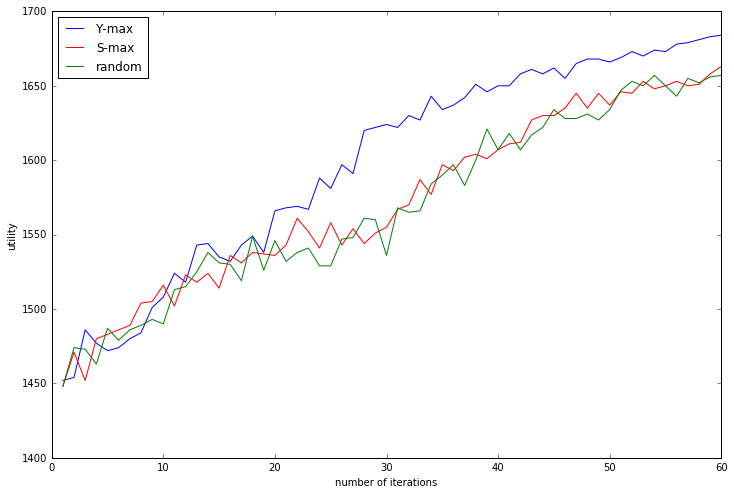

In [172]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 8)
plt.plot(range(1, 61), utility_2[:60], c='b', label='Y-max')
plt.plot(range(1, 61), utility_1[:60], c='r', label='S-max')
plt.plot(range(1, 61), utility_random[:60], c='g', label='random')
plt.ylabel('utility')
plt.xlabel('number of iterations')
pylab.legend(loc='best')

Мы видим, что Y-max в целом лучше справляется. S-max вообще не дает какого-то значимого прироста по сравнению со случайным выбором произвольного паросочетания.

Что касается максимальное количества итераций, то мы видим, что для разных алогитмов это число немного отличается. Но во всех случаях оно было больше $m - n + 1 = 38$ 